# 03. Convolutional Neural Networks and Computer Vision with TensorFlow



In [ ]:
import os
import zipfile
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **MAKE SURE GPU IS ENABLED!**

# 3.1 Binary Classification of Images

## 3.1.1 Dataset

Because convolutional neural networks work so well with images, to learn more about them, we're going to start with a dataset of images.

The images we're going to work with are from the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), a collection of 101 different categories of 101,000 (1000 images per category) real-world images of food dishes. 

To begin, we're only going to use two of the categories, pizza 🍕 and steak 🥩 and build a binary classifier.

> 🔑 **Note:** To prepare the data we're using, preprocessing steps such as, moving the images into different subset folders, have been done. To see these preprocessing steps check out [the preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

We'll download the `pizza_steak` subset .zip file and unzip it.

In [ ]:
# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-06-14 18:10:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.199.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   195MB/s    in 0.5s    

2022-06-14 18:10:57 (195 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [ ]:
!pwd

/content


In [ ]:
!rm -rf pizza_steak.zip

In [ ]:
!ls

pizza_steak  sample_data


### 3.1.2 Inspection Dataset Directory

In [ ]:
!ls pizza_steak

test  train


In [ ]:
!ls pizza_steak/train/

pizza  steak


In [ ]:
!ls pizza_steak/train/steak/ | head -n 5

1000205.jpg
100135.jpg
101312.jpg
1021458.jpg
1032846.jpg


In [ ]:
# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.
There are 2 directories and 0 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.


In [ ]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))
num_steak_images_train

750

In [ ]:
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


### 3.1.3 Inspect an Image

In [ ]:
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (384, 512, 3)


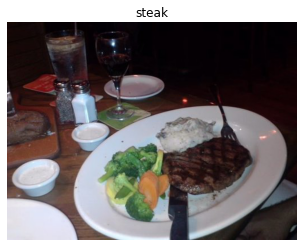

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train/", target_class="steak")

Image shape: (512, 384, 3)


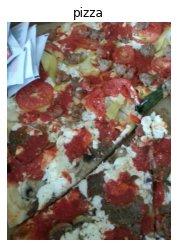

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train/", target_class="pizza")

### 3.1.4 Inspect image as a tensor

In [ ]:
# View the img (actually just a big array/tensor)
img.shape

(512, 384, 3)

Looking at the image shape more closely, you'll see it's in the form `(Width, Height, Colour Channels)`.

In our case, the width and height vary but because we're dealing with colour images, the colour channels value is always 3. This is for different values of [red, green and blue (RGB) pixels](https://en.wikipedia.org/wiki/RGB_color_model).

You'll notice all of the values in the `img` array are between 0 and 255. This is because that's the possible range for red, green and blue values.

For example, a pixel with a value `red=0, green=0, blue=255` will look very blue.

So when we build a model to differentiate between our images of `pizza` and `steak`, it will be finding patterns in these different pixel values which determine what each class looks like.

> 🔑 **Note:** As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also referred to as **normalize**) their pixel values by dividing the image arrays by 255.

In [ ]:
img.max()

255

In [ ]:
tf.reduce_max(img, axis=[0, 1])

<tf.Tensor: shape=(3,), dtype=uint8, numpy=array([255, 255, 255], dtype=uint8)>

In [ ]:
tf.reduce_max(img, axis=[0, 1, 2])

<tf.Tensor: shape=(), dtype=uint8, numpy=255>

In [ ]:
tf.reduce_min(img, axis=[0, 1])

<tf.Tensor: shape=(3,), dtype=uint8, numpy=array([0, 0, 0], dtype=uint8)>

In [ ]:
tf.reduce_min(img, axis=[0, 1, 2])

<tf.Tensor: shape=(), dtype=uint8, numpy=0>

## 3.1.5 Dataset Generators

In [ ]:
img.shape

(512, 384, 3)

In [ ]:
# Some models need pixel values between 0 and 1, so we would need to rescale them when loading images
tf.reduce_max(img * 1./255, axis=[0, 1, 2]) 

<tf.Tensor: shape=(), dtype=float64, numpy=1.0>

In [ ]:
tf.reduce_min(img * 1./255, axis=[0, 1, 2]) 

<tf.Tensor: shape=(), dtype=float64, numpy=0.0>

In [ ]:
# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42,
                                               )

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42,
                                               )

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
train_data.labels.shape

(1500,)

In [ ]:
img_batch, labels_batch = train_data[0]

In [ ]:
img_batch.shape

(32, 224, 224, 3)

In [ ]:
labels_batch.shape

(32,)

In [ ]:
labels_batch

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
train_data.class_indices

{'pizza': 0, 'steak': 1}

### 3.1.6 Architecture



In [ ]:
# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(6, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

In [ ]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 6)       546       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 6)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      550       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

#### a) Understanding Parameters in the Conv2D layer

In [ ]:
# Define the layers as functions
layer1 = tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3))
layer2 = tf.keras.layers.Conv2D(6, 3, activation="relu")

In [ ]:
# Take a batch
img_batch, labels_batch = train_data[0]

In [ ]:
# Forward it to layer 1
out1 = layer1(img_batch)

In [ ]:
out1.shape

TensorShape([32, 222, 222, 10])

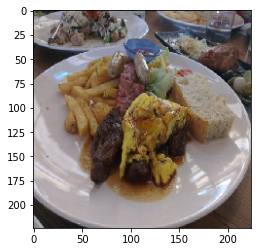

In [ ]:
# Original image
img_batch_rescaled = img_batch[0, ...] * 255.
plt.imshow(img_batch_rescaled.astype(np.uint8))

In [ ]:
# Calculate number of parameters
(10 #filters
  * 3*3*3 # squared kernel_size applied to 3 channels
  + 10 # each filter has 1 bias associated
)

280

#### b) Visualizing middle layers filters outputs

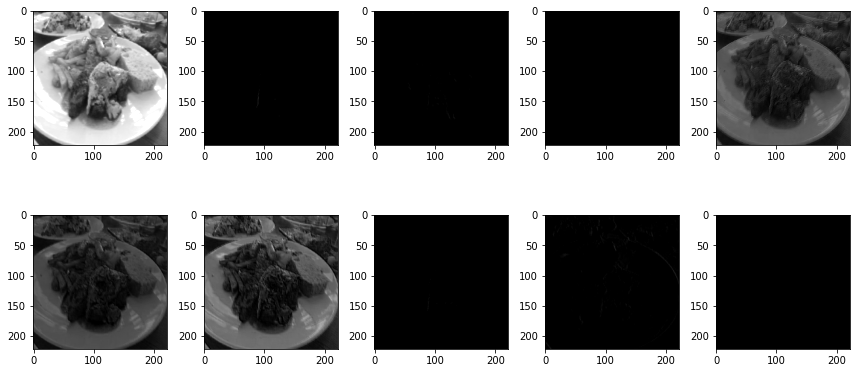

In [ ]:
rows = 2
cols = 5
fig, axs = plt.subplots(rows, cols, figsize=(12,6))

# Original image
col_num = 0
row_num = 0
for filter_num in range(0,rows * cols):
  out_batch_rescaled = out1[0, ..., filter_num] * 255.
  axs[row_num, col_num].imshow(out_batch_rescaled, cmap='gray', vmin=0, vmax=255)

  # Update the next position in the plot
  if col_num == cols-1:
    col_num = 0
    row_num += 1
  else:
    col_num += 1
plt.tight_layout()
  


In [ ]:
# Forward it to layer 12
out2 = layer2(out1)

In [ ]:
out2.shape

TensorShape([32, 220, 220, 6])

In [ ]:
# Calculate number of parameters
(6 #filters
  * 3*3*10 # squared kernel_size applied to 10 channels
  + 6 # each filter has 1 bias associated
)

546

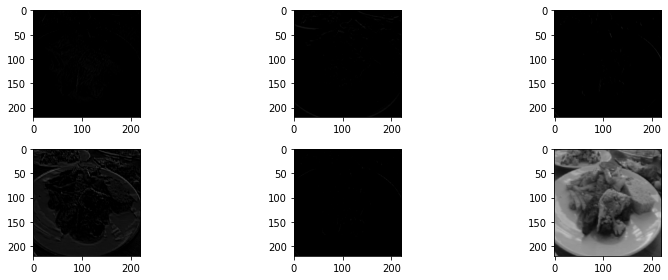

In [ ]:
rows = 2
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(12,4))

# Original image
col_num = 0
row_num = 0
for filter_num in range(0,rows * cols):
  out_batch_rescaled = out2[0, ..., filter_num] * 255.
  axs[row_num, col_num].imshow(out_batch_rescaled, cmap='gray', vmin=0, vmax=255)

  # Update the next position in the plot
  if col_num == cols-1:
    col_num = 0
    row_num += 1
  else:
    col_num += 1
plt.tight_layout()
  


In [ ]:
# Wrap the rest of layers into a sequential class, and apply it to the out2 tensor
rest_layers = tf.keras.models.Sequential([
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
])

In [ ]:
out3 = rest_layers(out2)

In [ ]:
out3.shape

TensorShape([32, 53, 53, 10])

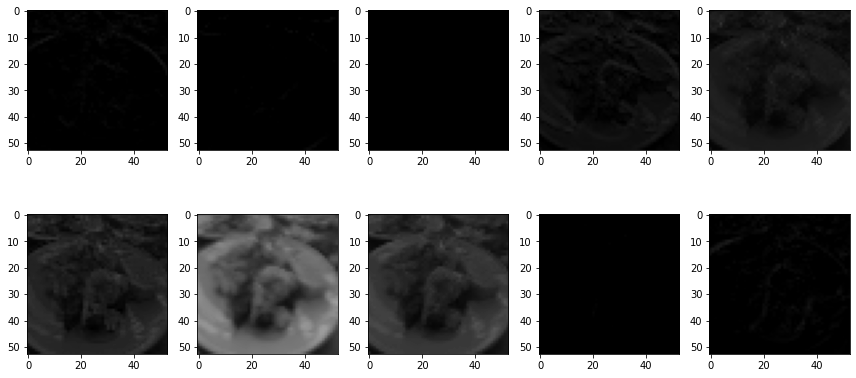

In [ ]:
rows = 2
cols = 5
fig, axs = plt.subplots(rows, cols, figsize=(12,6))

# Original image
col_num = 0
row_num = 0
for filter_num in range(0,rows * cols):
  out_batch_rescaled = out3[0, ..., filter_num] * 255.
  axs[row_num, col_num].imshow(out_batch_rescaled, cmap='gray', vmin=0, vmax=255)

  # Update the next position in the plot
  if col_num == cols-1:
    col_num = 0
    row_num += 1
  else:
    col_num += 1
plt.tight_layout()
  


### 3.1.7 Train the model

In [ ]:
!nvidia-smi

Tue Jun 14 18:12:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    26W /  70W |   2838MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

> 🤔 **Note:** If the cell below takes more than ~12 seconds per epoch to run, you might not be using a GPU accelerator. If you're using a Colab notebook, you can access a GPU accelerator by going to Runtime -> Change Runtime Type -> Hardware Accelerator and select "GPU". After doing so, you might have to rerun all of the above cells as changing the runtime type causes Colab to have to reset.



In [ ]:
# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=15,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/15
47/47 [==============================] - 11s 217ms/step - loss: 0.6080 - accuracy: 0.6640 - val_loss: 0.4495 - val_accuracy: 0.7840
Epoch 2/15
47/47 [==============================] - 9s 193ms/step - loss: 0.4442 - accuracy: 0.7947 - val_loss: 0.3730 - val_accuracy: 0.8460
Epoch 3/15
47/47 [==============================] - 12s 248ms/step - loss: 0.4182 - accuracy: 0.8167 - val_loss: 0.3510 - val_accuracy: 0.8480
Epoch 4/15
47/47 [==============================] - 11s 241ms/step - loss: 0.3993 - accuracy: 0.8227 - val_loss: 0.4060 - val_accuracy: 0.8060
Epoch 5/15
47/47 [==============================] - 9s 193ms/step - loss: 0.3573 - accuracy: 0.8493 - val_loss: 0.3126 - val_accuracy: 0.8780
Epoch 6/15
47/47 [==============================] - 9s 191ms/step - loss: 0.3193 - accuracy: 0.8593 - val_loss: 0.2943 - val_accuracy: 0.8760
Epoch 7/15
47/47 [==============================] - 9s 194ms/step - loss: 0.3151 - accuracy: 0.8693 - val_loss: 0.2902 - val_accuracy: 0.8680
Epo

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

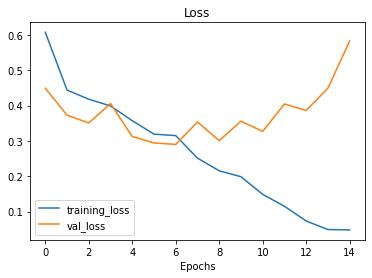

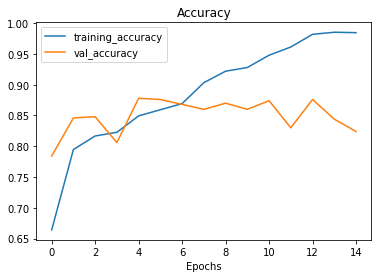

In [ ]:
# Check out the loss curves of model_1
plot_loss_curves(history_1)

**This is the precise definition of OVERFITTING**

### 6. Adjust the model parameters

Fitting a machine learning model  comes in 3 steps:
0. Create a basline.
1. Beat the baseline by overfitting a larger model.
2. Reduce overfitting.

So far we've gone through steps 0 and 1.

And there are even a few more things we could try to further overfit our model:
* Increase the number of convolutional layers.
* Increase the number of convolutional filters.
* Add another dense layer to the output of our flattened layer.

But what we'll do instead is focus on getting our model's training curves to better align with eachother, in other words, we'll take on step 2.

Why is reducing overfitting important?

When a model performs too well on training data and poorly on unseen data, it's not much use to us if we wanted to use it in the real world.

Say we were building a pizza vs. steak food classifier app, and our model performs very well on our training data but when users tried it out, they didn't get very good results on their own food images, is that a good experience?

Not really...

### 3.1.8 Data Augmentation

In [ ]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)


In [ ]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


> 🤔 **Question:** What's data augmentation?

**Data augmentation** is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.

Doing this simulates the kind of data a model might be used on in the real world.

If we're building a pizza vs. steak application, not all of the images our users take might be in similar setups to our training data. Using data augmentation gives us another way to prevent overfitting and in turn make our model more generalizable.

> 🔑 **Note:** Data augmentation is usally only performed on the training data. Using the `ImageDataGenerator` built-in data augmentation parameters our images are left as they are in the directories but are randomly manipulated when loaded into the model.

In [ ]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

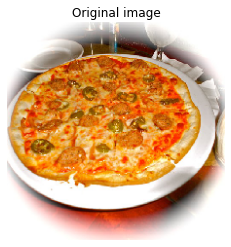

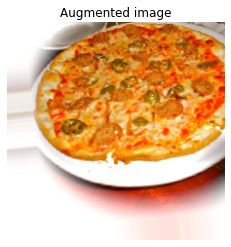

In [ ]:
# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

> 🤔 **Question:** Should I use data augmentation? And how much should I augment?

Data augmentation is a way to try and prevent a model overfitting. If your model is overfiting (e.g. the validation loss keeps increasing), you may want to try using data augmentation.

As for how much to data augment, there's no set practice for this. Best to check out the options in the `ImageDataGenerator` class and think about how a model in your use case might benefit from some data augmentation.

Now we've got augmented data, let's try and refit a model on it and see how it affects training.

We'll use the same model as `model_1`.

In [ ]:
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=True)

Found 1500 images belonging to 2 classes.


In [ ]:
# Create a CNN model the same as model_1
model_2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(6, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

In [ ]:
# Compile the model 2
model_2.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Fit the model
history_2 = model_2.fit(train_data_augmented, # changed to augmented training data !!!!
                        epochs=15,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/15
47/47 [==============================] - 24s 492ms/step - loss: 0.6944 - accuracy: 0.5933 - val_loss: 0.5706 - val_accuracy: 0.7780
Epoch 2/15
47/47 [==============================] - 23s 490ms/step - loss: 0.5536 - accuracy: 0.7340 - val_loss: 0.4391 - val_accuracy: 0.7920
Epoch 3/15
47/47 [==============================] - 23s 488ms/step - loss: 0.5207 - accuracy: 0.7487 - val_loss: 0.4106 - val_accuracy: 0.8420
Epoch 4/15
47/47 [==============================] - 23s 488ms/step - loss: 0.4855 - accuracy: 0.7747 - val_loss: 0.3629 - val_accuracy: 0.8540
Epoch 5/15
47/47 [==============================] - 23s 498ms/step - loss: 0.4570 - accuracy: 0.7913 - val_loss: 0.3296 - val_accuracy: 0.8560
Epoch 6/15
47/47 [==============================] - 23s 488ms/step - loss: 0.4598 - accuracy: 0.7953 - val_loss: 0.3332 - val_accuracy: 0.8700
Epoch 7/15
47/47 [==============================] - 23s 487ms/step - loss: 0.4547 - accuracy: 0.7927 - val_loss: 0.3844 - val_accuracy: 0.8220

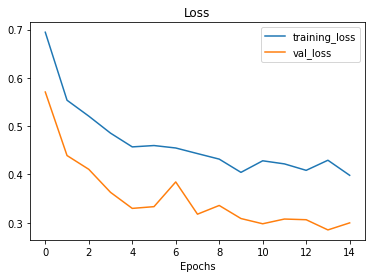

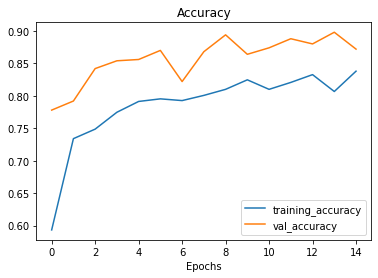

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_2)

**We have corrected overfitting and also enhanced performance on Validation**

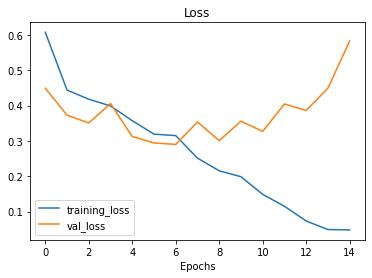

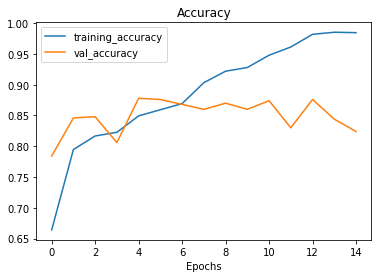

In [ ]:
# Compare with the previous performance without data augmentation
plot_loss_curves(history_1)

# 3.1.9 Making a Prediction

In [ ]:
# Let's get some user made images which haven't seen previously by the algorithm
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

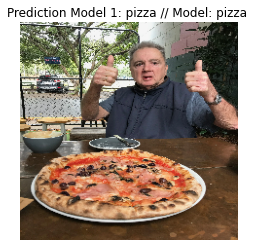

In [ ]:
# Import the target image and preprocess it
img = load_and_prep_image('03-pizza-dad.jpeg')

# Make a prediction
pred1 = model_1.predict(tf.expand_dims(img, axis=0))
pred2 = model_2.predict(tf.expand_dims(img, axis=0))

# Get the predicted class
pred_class1 = class_names[int(tf.round(pred1)[0][0])]
pred_class2 = class_names[int(tf.round(pred2)[0][0])]

# Plot the image and predicted class
plt.imshow(img)
plt.title(f"Prediction Model 1: {pred_class1} // Model 2: {pred_class2} ")
plt.axis(False);

In [ ]:
test_data.class_indices

{'pizza': 0, 'steak': 1}

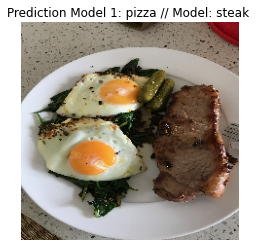

In [ ]:
# Import the target image and preprocess it
img = load_and_prep_image('03-steak.jpeg')

# Make a prediction
pred1 = model_1.predict(tf.expand_dims(img, axis=0))
pred2 = model_2.predict(tf.expand_dims(img, axis=0))

# Get the predicted class
pred_class1 = class_names[int(tf.round(pred1)[0][0])]
pred_class2 = class_names[int(tf.round(pred2)[0][0])]

# Plot the image and predicted class
plt.imshow(img)
plt.title(f"Prediction Model 1: {pred_class1} // Model 2: {pred_class2} ")
plt.axis(False);

In [ ]:
pred1

array([[0.23379037]], dtype=float32)

In [ ]:
pred2

array([[0.9355578]], dtype=float32)

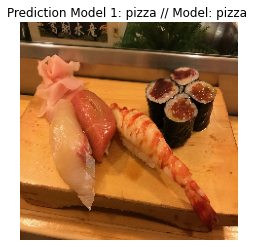

In [ ]:
# Import the target image and preprocess it
img = load_and_prep_image('03-sushi.jpeg')

# Make a prediction
pred1 = model_1.predict(tf.expand_dims(img, axis=0))
pred2 = model_2.predict(tf.expand_dims(img, axis=0))

# Get the predicted class
pred_class1 = class_names[int(tf.round(pred1)[0][0])]
pred_class2 = class_names[int(tf.round(pred2)[0][0])]

# Plot the image and predicted class
plt.imshow(img)
plt.title(f"Prediction Model 1: {pred_class1} // Model 2: {pred_class2} ")
plt.axis(False);

In [ ]:
pred1

array([[0.00318844]], dtype=float32)

In [ ]:
pred2

array([[0.20272598]], dtype=float32)